<a href="https://colab.research.google.com/github/isaaccorley/torchgeo/blob/transforms%2Findices/docs/tutorials/transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Transforms

In this tutorial, we demonstrate how to use TorchGeo's unique functions and transforms and provide examples of how to utilize them in your experiments with multispectral imagery.

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

## Setup

Install TorchGeo

In [ ]:
%pip install 'git+https://github.com/isaaccorley/torchgeo.git@transforms/indices'

Install additional libraries

In [18]:
%pip install tifffile

Download the EuroSat Multispectral (MS) Sentinel-2 dataset (~2.8GB)

In [19]:
import os
from torchgeo.datasets.utils import download_and_extract_archive

os.makedirs("eurosat", exist_ok=True)
download_and_extract_archive(
    url="http://madm.dfki.de/files/sentinel/EuroSATallBands.zip",
    download_root=".",
    extract_root="eurosat"
)

  0%|          | 0/2067725275 [00:00<?, ?it/s]

Extracting ./EuroSATallBands.zip to eurosat


## Imports

In [20]:
import os
from typing import List

import kornia
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import rasterio
import rasterio.features
import shapely
import tifffile
import torch
import torch.nn as nn
import torchvision.transforms as T
from osgeo import gdal
from PIL import Image
from rasterio.plot import show
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

from torchgeo.datasets.utils import download_url
from torchgeo.transforms import AugmentationSequential, indices

## Custom Image Transforms

- `MinMaxNormalize` normalizes the band values to a common range between [0, 1].
- `ToTensor` converts the images from numpy arrays to torch Tensors and swaps the channel dimension from `HWC` to `CHW`.

In [21]:
class MinMaxNormalize(nn.Module):
  """ Normalize channels to the range [0, 1] using min/max values """
  def __init__(self, min: List[float], max: List[float]):
    super().__init__()
    self.min = torch.tensor(min)[:, None, None]
    self.max = torch.tensor(max)[:, None, None]
    self.denominator = (self.max - self.min)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = (x - self.min) / self.denominator
    x = x.clip(0, 1)
    return x

class ToTensor(nn.Module):
  def forward(self, x: np.ndarray) -> torch.Tensor:
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.permute((2, 0, 1))
    return x

## Dataset Bands and Statistics

In [22]:
mins = [1013.0, 676.0, 448.0, 247.0, 269.0, 253.0, 243.0, 189.0, 61.0, 4.0, 33.0, 11.0, 186.0]
maxs = [2309.0, 4543.05, 4720.2, 5293.05, 3902.05, 4473.0, 5447.0, 5948.05, 1829.0, 23.0, 4894.05, 4076.05, 5846.0]
bands = {
  "B1": "Coastal Aerosol",
  "B2": "Blue",
  "B3": "Green",
  "B4": "Red",
  "B5": "Vegetation Red Edge 1",
  "B6": "Vegetation Red Edge 2",
  "B7": "Vegetation Red Edge 3",
  "B8": "NIR 1",
  "B8A": "NIR 2",
  "B9": "Water Vapour",
  "B10": "SWIR 1",
  "B11": "SWIR 2",
  "B12": "SWIR 3"
}

## Load the EuroSat MS dataset and dataloader

Here we load the EuroSat Multispectral (MS) dataset. The dataset contains  27,000 64x64 Sentinel-2 multispectral patches with 10 land cover classes.

In [23]:
root = "eurosat"
root = os.path.join(root, "ds/images/remote_sensing/otherDatasets/sentinel_2/tif")
transform = T.Compose([ToTensor(), MinMaxNormalize(mins, maxs)])
dataset = ImageFolder(
  root=root,
  transform=transform,
  loader=tifffile.imread
)
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)
dataloader = iter(dataloader)
print(f"Number of images in dataset: {len(dataset)}")
print(f"Dataset Classes: {dataset.classes}")

Number of images in dataset: 27000
Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Load a sample image and class label

Here we test our dataset by loading a single image and label. Note how the image is of shape (13, 64, 64) containing a 64x64 shape with 13 multispectral bands.

In [24]:
x, y = dataset[0]
print(x.shape, x.dtype, x.min(), x.max())
print(y, dataset.classes[y])

torch.Size([13, 64, 64]) torch.float32 tensor(0.0843) tensor(0.7112)
0 AnnualCrop


## Indices Transforms Usage

Indices can be computed easily using the functional interfaces.

In [25]:
index = indices.ndvi(red=x[3], nir=x[7])
print(index.shape, index.min(), index.max())

torch.Size([64, 64]) tensor(0.0618) tensor(0.5265)


Indices can also be computed on batches of images and appended as an additional band to the specified channel dimension. Notice how the number of channels increases from 13 -> 14.

In [27]:
transform = indices.AppendNDVI(index_red=3, index_nir=7)
x, y = next(dataloader)
batch = {"image": x, "label": y}
print(batch["image"].shape)
batch = transform(batch)
print(batch["image"].shape)

torch.Size([4, 13, 64, 64])
torch.Size([4, 14, 64, 64])


This makes it incredibly easy to add indices as additional features during training by chaining multiple Appends together.

In [28]:
transforms = nn.Sequential(
  indices.AppendNDBI(index_swir=11, index_nir=7),
  indices.AppendNDSI(index_green=3, index_swir=11),
  indices.AppendNDVI(index_red=3, index_nir=7),
  indices.AppendNDWI(index_green=2, index_nir=7),
)

x, y = next(dataloader)
batch = {"image": x, "label": y}
print(batch["image"].shape)
batch = transforms(batch)
print(batch["image"].shape)

torch.Size([4, 13, 64, 64])
torch.Size([4, 17, 64, 64])


It's even possible to chain indices along with augmentations from kornia for a single callable during training.

In [29]:
augmentations = AugmentationSequential(
  K.RandomHorizontalFlip(p=0.5),
  K.RandomVerticalFlip(p=0.5),
  data_keys=["image"],
)
transforms = nn.Sequential(
  indices.AppendNDBI(index_swir=11, index_nir=7),
  indices.AppendNDSI(index_green=3, index_swir=11),
  indices.AppendNDVI(index_red=3, index_nir=7),
  indices.AppendNDWI(index_green=2, index_nir=7),
  augmentations
)

x, y = next(dataloader)
batch = {"image": x, "label": y}
print(batch["image"].shape)
batch = transforms(batch)
print(batch["image"].shape)



torch.Size([4, 13, 64, 64])
torch.Size([4, 17, 64, 64])


## Visualize Images and Labels

Class Label: Highway


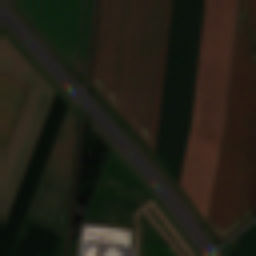

In [36]:
#@title EuroSat Multispectral (MS) Browser  { run: "auto", vertical-output: true }
idx = 9889 #@param {type:"slider", min:0, max:26999, step:1}
x, y = dataset[idx]
rgb = x[1:4]
rgb = rgb[[2, 1, 0], ...]
image = T.ToPILImage()(rgb)
print(f"Class Label: {dataset.classes[y]}")
image.resize((256, 256), resample=Image.BILINEAR)